# Image Classification (Intro) on a Raspi with TFLite
## [Image Classification Fundamentals - MobileNet V2](https://mjrovai.github.io/EdgeML_Made_Ease_ebook/raspi/image_classification/image_classification_fund.html#making-inferences-with-mobilenet-v2)
by MJRovai @ 18Aug2025

## Import data (Optional)

To download all images from the [GitHub directory](https://github.com/Mjrovai/EdgeML-with-Raspberry-Pi/tree/main/IMG_CLASS/images), we should use DownGit (Recommended for Simplicity)
- Visit the DownGit tool: https://download-directory.github.io
	•	Paste the URL of the images folder:
`https://github.com/Mjrovai/EdgeML-with-Raspberry-Pi/tree/main/IMG_CLASS/images`
	•	Click “Download” to get a ZIP file containing all images from the folder.

Open the Zip File on your desktop and transfer the images to the Raspberry Pi using FileZilla.

## Import libraries

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tflite_runtime.interpreter as tflite

/home/mjrovai/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## Main functions

In [3]:
# Function to load labels
def load_labels(filename):
    with open(filename, 'r') as f:
        return [line.strip() for line in f.readlines()]

In [4]:
model_path = "./models/mobilenet_v2_1.0_224_quant.tflite"
img_path = "./images/Cat03.jpg"
labels_path = "./models/labels.txt"

In [5]:
# Load the TFLite model
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [6]:
input_details

[{'name': 'input',
  'index': 171,
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([  1, 224, 224,   3], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128),
  'quantization_parameters': {'scales': array([0.0078125], dtype=float32),
   'zero_points': array([128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
output_details

[{'name': 'output',
  'index': 172,
  'shape': array([   1, 1001], dtype=int32),
  'shape_signature': array([   1, 1001], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (0.09889253973960876, 58),
  'quantization_parameters': {'scales': array([0.09889254], dtype=float32),
   'zero_points': array([58], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [8]:
# Load he image
img = Image.open(img_path)

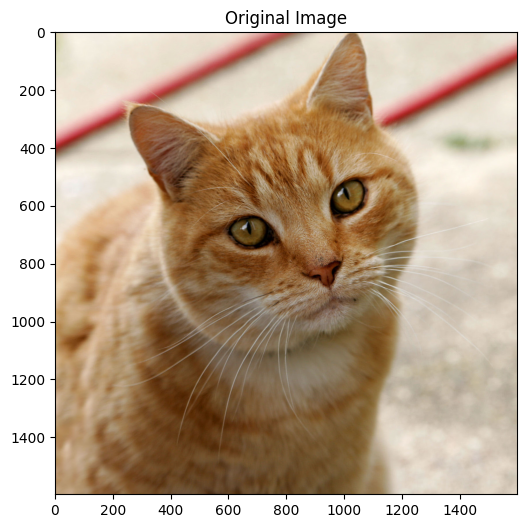

In [10]:
# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
#plt.axis('off')  # This turns off the axis numbers
plt.title("Original Image")
plt.show()

In [11]:
width, height = img.size
channels = len(img.getbands())
shape = (height, width, channels)

print(f"Image shape: {shape}")

Image shape: (1598, 1600, 3)


In [12]:
# Preprocess the image
img = img.resize((input_details[0]['shape'][1], input_details[0]['shape'][2]))
input_data = np.expand_dims(img, axis=0)
input_data.shape

(1, 224, 224, 3)

In [13]:
# Get dtype of the input data
input_data.dtype

dtype('uint8')

In [14]:
# Get dtype of the input details of the model
input_dtype = input_details[0]['dtype']
input_dtype

numpy.uint8

The input data dtype is 'uint8', which is compatible with the dtype expected for the model

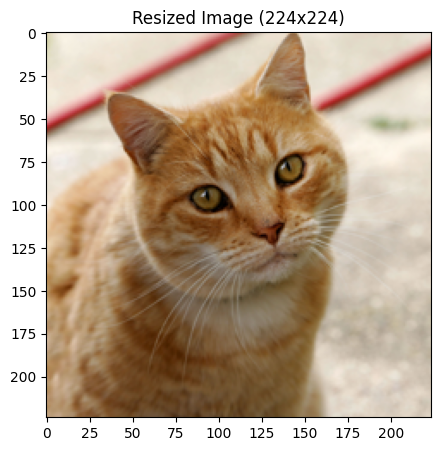

In [15]:
# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(img)
#plt.axis('off')  # This turns off the axis numbers
plt.title("Resized Image (224x224)")
plt.show()

In [16]:
# Inference on Raspi-Zero
start_time = time.time()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
end_time = time.time()
inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
print ("Inference time: {:.1f}ms".format(inference_time))

Inference time: 361.6ms


In [17]:
# Obtain results and map them to the classes
predictions = interpreter.get_tensor(output_details[0]['index'])[0]

In [18]:
predictions

array([ 49,  53,  71, ...,  38,  74, 104], dtype=uint8)

In [19]:
predictions.shape

(1001,)

In [20]:
# Get indices of the top k results
top_k_results = 5
top_k_indices = np.argsort(predictions)[::-1][:top_k_results]
top_k_indices

array([283, 286, 282, 288, 479])

In [21]:
# Load labels
labels = load_labels(labels_path)

In [22]:
print(labels[286])
print(labels[283])
print(labels[282])
print(labels[288])
print(labels[479])

Egyptian cat
tiger cat
tabby
lynx
carton


In [23]:
print (predictions[286])
print (predictions[283])
print (predictions[282])
print (predictions[288])
print (predictions[479])

168
171
163
158
143


In [24]:
# Get quantization parameters
scale, zero_point = output_details[0]['quantization']
scale, zero_point

(0.09889253973960876, 58)

In [25]:
# Dequantize the output
dequantized_output = (predictions.astype(np.float32) - zero_point) * scale
dequantized_output

array([-0.8900329, -0.4944627,  1.285603 , ..., -1.9778508,  1.5822806,
        4.549057 ], dtype=float32)

The output (positive and negative numbers) shows that the output probably does not have a Softmax. Checking the model documentation (https://arxiv.org/abs/1801.04381v4): MobileNet V2 typically doesn't include a softmax layer at the output. It usually ends with a 1x1 convolution followed by average pooling and a fully connected layer. So, for getting the probabilities (0 t0 1), we should apply Softmax:

In [26]:
# Apply softmax
exp_output = np.exp(dequantized_output - np.max(dequantized_output))
probabilities = exp_output / np.sum(exp_output)

In [27]:
probabilities 

array([2.1491151e-06, 3.1919305e-06, 1.8928949e-05, ..., 7.2414616e-07,
       2.5466632e-05, 4.9479620e-04], dtype=float32)

In [28]:
# If we sum all values, we can get around 1.
probabilities.sum()

1.0000001

In [29]:
print (probabilities[286])
print (probabilities[283])
print (probabilities[282])
print (probabilities[288])
print (probabilities[479])

0.27741462
0.3732285
0.16919471
0.10319158
0.023410844


In [30]:
for i in range(top_k_results):
    print("\t{:20}: {}%".format(
        labels[top_k_indices[i]],
        (int(probabilities[top_k_indices[i]]*100))))

	tiger cat           : 37%
	Egyptian cat        : 27%
	tabby               : 16%
	lynx                : 10%
	carton              : 2%


### Testing with images

### Define a general Image Classification function

In [31]:
def image_classification(img_path, model_path, labels, top_k_results=5):
    # load the image
    img = Image.open(img_path)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    # Load the TFLite model
    interpreter = tflite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess
    img = img.resize((input_details[0]['shape'][1], 
                      input_details[0]['shape'][2]))
    input_data = np.expand_dims(img, axis=0)

    # Inference on Raspi-Zero
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    # Obtain results and map them to the classes
    predictions = interpreter.get_tensor(output_details[0]['index'])[0]

    # Get indices of the top k results
    top_k_indices = np.argsort(predictions)[::-1][:top_k_results]

    # Get quantization parameters
    scale, zero_point = output_details[0]['quantization']

    # Dequantize the output and apply softmax
    dequantized_output = (predictions.astype(np.float32) - zero_point) * scale
    exp_output = np.exp(dequantized_output - np.max(dequantized_output))
    probabilities = exp_output / np.sum(exp_output)

    print("\n\t[PREDICTION]        [Prob]\n")
    for i in range(top_k_results):
        print("\t{:20}: {}%".format(
            labels[top_k_indices[i]],
            (int(probabilities[top_k_indices[i]]*100))))

In [32]:
model_path = "./models/mobilenet_v2_1.0_224_quant.tflite"
img_path = "./images/Cat03.jpg"
labels_path = "./models/labels.txt"
labels = load_labels(labels_path)


	[PREDICTION]        [Prob]

	tiger cat           : 37%
	Egyptian cat        : 27%
	tabby               : 16%
	lynx                : 10%
	carton              : 2%


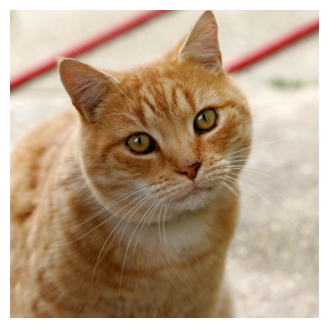

In [33]:
image_classification(img_path, model_path, labels, top_k_results=5)

In [34]:
!ls ./images

car_1.jpg  car_4.jpg  cat_1.jpg  cup.jpg    dog_3.jpg	  ship_1.jpg
car_2.jpg  car_5.jpg  cat_2.jpg  dog_1.jpg  images	  ship_2.jpg
car_3.jpg  Cat03.jpg  cat_2.png  dog_2.jpg  img_test.jpg



	[PREDICTION]        [Prob]

	sports car          : 92%
	car wheel           : 2%
	racer               : 2%
	beach wagon         : 1%
	convertible         : 0%


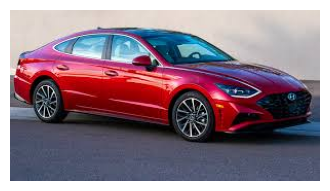

In [35]:
img_path = "./images/car_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	minivan             : 37%
	car wheel           : 16%
	sports car          : 12%
	beach wagon         : 12%
	jeep                : 8%


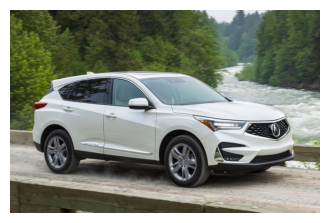

In [36]:
img_path = "./images/car_2.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	minivan             : 27%
	sports car          : 27%
	grille              : 14%
	beach wagon         : 14%
	car wheel           : 5%


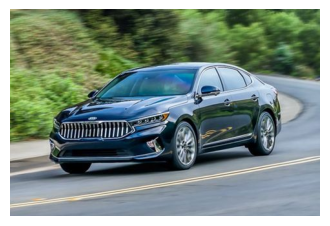

In [37]:
img_path = "./images/car_3.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	sports car          : 68%
	racer               : 14%
	passenger car       : 3%
	cab                 : 3%
	car wheel           : 3%


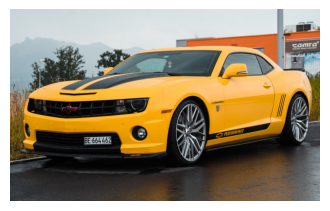

In [38]:
img_path = "./images/car_4.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	convertible         : 44%
	sports car          : 44%
	grille              : 5%
	minivan             : 1%
	pickup              : 0%


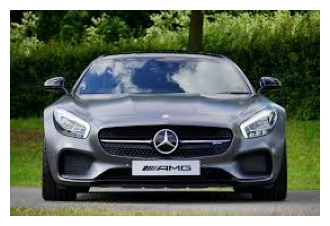

In [39]:
img_path = "./images/car_5.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	tabby               : 68%
	Egyptian cat        : 18%
	tiger cat           : 2%
	hamper              : 1%
	lynx                : 0%


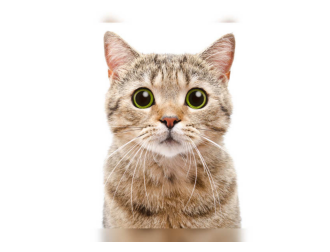

In [40]:
img_path = "./images/cat_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	tiger cat           : 43%
	Egyptian cat        : 24%
	tabby               : 16%
	lynx                : 8%
	carton              : 2%


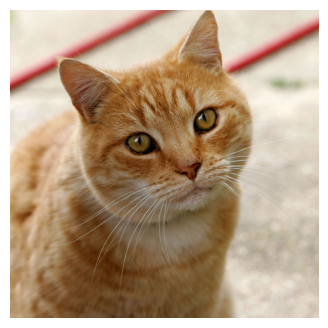

In [41]:
img_path = "./images/cat_2.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	Labrador retriever  : 82%
	golden retriever    : 6%
	bloodhound          : 2%
	kuvasz              : 1%
	Saluki              : 1%


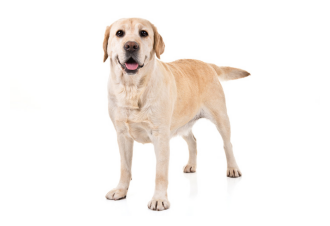

In [42]:
img_path = "./images/dog_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	Labrador retriever  : 60%
	dalmatian           : 6%
	Great Pyrenees      : 5%
	kuvasz              : 5%
	tennis ball         : 3%


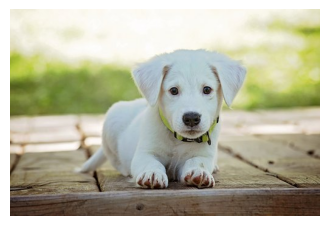

In [43]:
img_path = "./images/dog_2.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	Labrador retriever  : 99%
	Rhodesian ridgeback : 0%
	golden retriever    : 0%
	English foxhound    : 0%
	Great Dane          : 0%


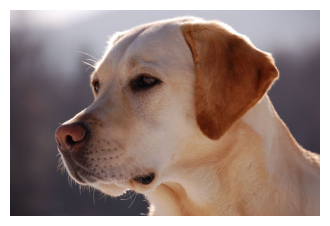

In [44]:
img_path = "./images/dog_3.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	liner               : 78%
	catamaran           : 4%
	container ship      : 4%
	drilling platform   : 2%
	wreck               : 1%


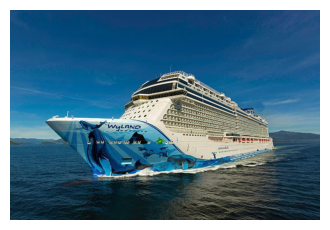

In [45]:
img_path = "./images/ship_1.jpg"
image_classification(img_path, model_path, labels)


	[PREDICTION]        [Prob]

	schooner            : 95%
	pirate              : 2%
	yawl                : 1%
	dock                : 0%
	trimaran            : 0%


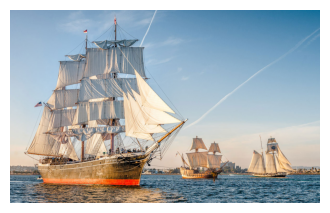

In [46]:
img_path = "./images/ship_2.jpg"
image_classification(img_path, model_path, labels)

In [47]:
ls

10_Image_Classification.ipynb  image_classification.ipynb  models/
cam_test.jpg                   images/


## Classifying Images from the Camera

In [48]:
from picamera2 import Picamera2

In [49]:
def capture_image(image_path):
    
  # Initialize camera
  picam2 = Picamera2() # default is index 0

  # Configure the camera
  config = picam2.create_still_configuration(main={"size": (224, 224)})
  picam2.configure(config)
  picam2.start()

  # Wait for the camera to warm up
  time.sleep(2)

  # Capture image
  picam2.capture_file(image_path)
  print("Image captured: "+"image_path")

  # Stop camera
  picam2.stop()
  picam2.close()

[0:44:37.501041678] [650]  INFO Camera camera_manager.cpp:326 libcamera v0.5.1+100-e53bdf1f
[0:44:37.704626408] [1988]  WARN RPiSdn sdn.cpp:40 Using legacy SDN tuning - please consider moving SDN inside rpi.denoise
[0:44:37.710356671] [1988]  INFO RPI vc4.cpp:440 Registered camera /base/soc/i2c0mux/i2c@1/ov5647@36 to Unicam device /dev/media0 and ISP device /dev/media1
[0:44:37.710471306] [1988]  INFO RPI pipeline_base.cpp:1107 Using configuration file '/usr/share/libcamera/pipeline/rpi/vc4/rpi_apps.yaml'
[0:44:37.758342526] [650]  INFO Camera camera.cpp:1205 configuring streams: (0) 224x224-BGR888/sRGB (1) 640x480-SGBRG10_CSI2P/RAW
[0:44:37.759148777] [1988]  INFO RPI vc4.cpp:615 Sensor: /base/soc/i2c0mux/i2c@1/ov5647@36 - Selected sensor format: 640x480-SGBRG10_1X10 - Selected unicam format: 640x480-pGAA


Image captured: image_path

	[PREDICTION]        [Prob]

	coffee mug          : 92%
	toaster             : 1%
	lighter             : 0%
	cup                 : 0%
	buckle              : 0%


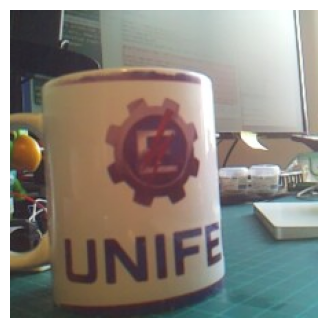

In [50]:
img_path = './images/cam_img_test.jpg'
model_path = "./models/mobilenet_v2_1.0_224_quant.tflite"
labels = load_labels("./models/labels.txt")
capture_image(img_path)
image_classification(img_path, model_path, labels, top_k_results=5)